<a href="https://colab.research.google.com/github/JorgeTonatiuh/Tarea_1/blob/main/retropropagacion_en_red_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retropropagación en red densa.

Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas. Esta red tiene una función de activación logística en todas sus neuronas y se entrena minimizando la función de pérdida de entropía cruzada binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.

In [135]:
from sklearn import datasets
import numpy as np
import pandas as pd

## Dataset

Para entrenar el modelo se utilizará el dataset de flores iris el cual contiene la información de 3 clases de estas flores.

1.- Las 3 clases de iris son: 

1.   Iris Setosa
2.   Iris Versicolour
3.   Iris Virginica

2.- Los atributos que contiene el dataset son:

1.   Longitud del sépalo
2.   Ancho del sépalo
3.   Longitud del pétalo
4.   Ancho del pétalo

3.- Número de instancias: 150 (50 en cada una de las tres clases)

4.- Este dataset no contiene valores faltantes

In [136]:
#Se obiene el dataset utilizando sklearn datasets
iris = datasets.load_iris()

In [137]:
#Se obtiene la data de los atributos
data = iris.data

In [138]:
#Se obtiene el target
#Dado que las clases estan representadas numericamente en el dataset original
#se transforman estas represaentaciones aplicando One-hot encoding
s = pd.Series(iris.target)
target = pd.get_dummies(s).to_numpy()

## Entrenamiento del modelo

La red esta compuesta por una capa de 4 entradas $(x_1,x_2,x_3,x_4)$, dos capas ocultas con neuronas con función de activación sigmoide y una capa de salida con 3 neurnas con función de activación sigmoide. Esta función se define como:

$$σ(z)=\frac{1}{1+e^{-z}}$$


In [140]:
def sigmoide(z):
  return 1 / (1 + np.exp(-z))

Mas adelante se utilizará la derivada de la sigmoide para la retropagación entonces esta esta definida como:

$$\frac{∂σ(z)}{∂z}=σ(z)(1-σ(z))$$

In [141]:
def dsigmoide(z):
  return np.multiply(sigmoide(z),(1 - sigmoide(z)))

Dado que la tarea es de clasificación multietiqueta apartir de 4 entradas se utiliza como función de peridda la entropía cruzada binaria, la cual se define de la siguiente manera:

$$ECB(y,\hat{y})=-\sum_{i=1}^{N}[y^{(i)}log (\hat{y}^{(i)}) + (1-y^{(i)})log(1-\hat{y}^{(i)})]$$

In [142]:
def ECB(y,p):
  p[p == 0] = np.nextafter(0.,1.) #Para evitar logaritmos de 0
  p[p == 1] = np.nextafter(1.,0.) #Para evitar logaritmos de 1
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y==0]).sum())

Se define la exactitud como medida de evaluación del modelo.

In [143]:
def exactitud(y, y_pred):
  return (y == y_pred).mean() * 100

A continuación se define la funcion para propagar las entradas hacia adelante. 
Dado que la red esta compuesta de 3 capas densas, es decir, 2 ocultas y 1 de salida, tenemos 3 matrices de pesos con sus correspondientes vecotres de sesgos de las capas ocultas y la de salida. Con esto la propagacion hacia adelante queda de la siguiente forma:

$$a^{\{1\}}=x^{(i)}$$
$$z^{\{2\}}=W^{\{1\}}⋅a^{\{1\}}+b^1$$
$$a^{\{2\}}=σ(z^{\{2\}})$$
$$z^{\{3\}}=W^{\{3\}}⋅a^{\{3\}}+b^2$$
$$a^{\{3\}}=σ(z^{\{3\}})$$
$$z^{\{4\}}=W^{\{3\}}⋅a^{\{3\}}+b^3$$
$$a^{\{4\}}=σ(z^{\{4\}})$$
$$\hat{y}^{(i)}=a^4$$

Donde $\hat{y}^{(i)}$ es el valor de actualización de la capa de salida.


In [161]:
def adelante(x, W1, b1, W2, b2, W3, b3):
  a1 = x[:, np.newaxis]
  z2 = np.dot(W1.T, a1) + b1
  a2 = sigmoide(z2)
  z3 = np.dot(W2.T, a2) + b2
  a3 = sigmoide(z3)
  z4 = np.dot(W3.T, a3) + b3
  a4 = sigmoide(z4)
  y_hat = a4
  return z2,a2,z3,a3,z4,y_hat

A continuación se define la función para entrenar la red usando gradiente descendente. Se utiliza el algorimto de retropropagación para calcular el gradiente de la perdida respecto a los pesos y sesgos en cada capa. 

Para esto se debe de calcular el gradiente de la funcion de perdida con respecto a $W^{\{j\}}$ 

$$ECB(y,\hat{y})=-\sum_{i=1}^{N}[y^{(i)}log (\hat{y}^{(i)}) + (1-y^{(i)})log(1-\hat{y}^{(i)})]$$

$$\frac{∂ECB}{∂W^{\{j\}}} = \sum_{i=1}^{N}(\hat{y}^{(i)}-y^{(i)})⋅x_j^{(i)}$$

$$\frac{∂ECB}{∂b^{\{j\}}} = \sum_{i=1}^{N}(\hat{y}^{(i)}-y^{(i)})$$
Y la regla de actualización de parámetros esta dada por:
$$W^{\{j\}}=W^{\{j\}}-α\frac{∂ECB}{∂W^{\{j\}}}$$
$$b^{\{j\}}=b^{\{j\}}-σ\frac{∂ECB}{∂b^{\{j\}}}$$

Donde $σ$ es tasa de aprendizaje.

In [145]:
def retropropagacion(X,y, alpha = 0.01, n_epocas=100, n_ocultas = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]

  #Se inician los pesos W1, W2, W3 y sesgos
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((n_ocultas, 1))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas)
  b2 = np.zeros((n_ocultas,1))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 3)
  b3 = np.zeros((3,1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_pred = np.zeros((y.shape))
  for i in range(n_epocas):
    for j in range(n_ejemplos):
      z2, a2, z3, a3, z4, y_hat = adelante(X[j], W1, b1, W2, b2, W3, b3)

      #Se calcula el gradiente para W3 y b3
      dz4 = y_hat - y[j][:,np.newaxis]
      dW3 = np.outer(a3,dz4)
      db3 = dz4

      #Se calcula el gradiente para W2 y b2
      dz3 = np.dot(W3, dz4) * dsigmoide(z3)
      dW2 = np.outer(a2,dz3)
      db2 = dz3

      #Se calcula el gradiente para W1 y b1
      dz2 = np.dot(W2, dz3) * dsigmoide(z2)
      dW1 = np.outer(X[j], dz2)
      db1 = dz2

      #Se actualizan los parametros
      W3 = W3 - alpha * dW3
      b3 = b3 - alpha * db3
      W2 = W2 - alpha * dW2
      b2 = b2 - alpha * db2
      W1 = W1 - alpha * dW1
      b1 = b1 - alpha * db1

      y_pred[j][:,np.newaxis] = y_hat

    # Se calcula la perdida en la epoca 
    perdidas[i] = ECB(y, y_pred)
    #Se guarda la exactitud
    exactitudes[i] = exactitud(y, np.round(y_pred))

  return W1,W2,W3,b1,b2,b3,perdidas,exactitudes




Se procede a entrenar el modelo, se configura la red con una tasa de apredizaje $σ=0.01$, 4 neuronas en la capa de entrada (debido a que son 4 atributos de dataset de iris) 10 neuronas en cada capa oculta y 3 neuronas en la capa de salida, las cuales nos indican a que tipo de flor de iris corresponde y por último un número de épocas de 200.

In [146]:
np.random.seed(0)
W1,W2,W3,b1,b2,b3,perdidas,exactitudes = retropropagacion(data,target,alpha=0.01,n_epocas=200,n_ocultas=10)

Se grafica la perdida y la exactitud en cada una de las épocas para observar el compotamiento durante el entrenamiento de la red.

En la siguiente tabla se puede observar como en las primeras épocas la perdida tiene un valor muy alto, el cuál va disminuyendo conforme las épocas van avanzando, y para el caso de la exactitud esta inicia en un valor vajo y conforme pasan las épocas va aumentando, lo que nos indica que nuestro modelo va mejorando conforme pasan las épocas.

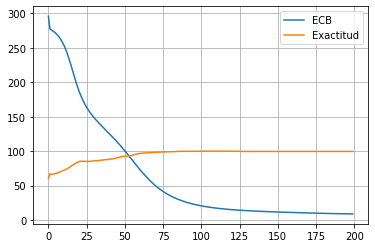

In [147]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size),perdidas,label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

## Evaluación

A continuación se evalua el modelo utilizando los pesos y sesgos obtenidos del entrenamiento.


In [159]:
n_ejemplos = data.shape[0]
y_pred = np.zeros((target.shape))
for j in range(n_ejemplos):
  _, _, _, _, _, y_hat = adelante(data[j], W1, b1, W2, b2, W3, b3)
  y_pred[j] = [int(i > .5) for i in y_hat]
  
print('Exactitud = ',exactitud(target, y_pred))

Exactitud =  95.11111111111111


Con la ayuda del algoritmo de retropropagación se pueden entrenar los modelos referentes a redes neuronales densas, lo único que se tendría que cambiar dependiendo el problema sería la función de pérdida, en este caso como se trata de un problema de clasificación binario de multietiquedas se utilizó la entropía cruzada binaria, pero esta tendría que cambiar si se trata de una tarea de regresión que se utilizaría un error cuadrático medio y al igual que se realizó con la ECB se tendría que obtener el gradiente para minimizar la función y definir la función de actualización, otra cosa que también se debe tomar en cuenta es el numero de capas a utilizar dado que esto afecta directamente en el cálculo de los pesos.
Además de la la función de pérdida también las funciones de activación utilizadas podrían cambiar.